#  Machine Learining Practical: Coursework 3

## Training Deep Neural Nteworks on CIFAR-100

In [6]:
import os
import tensorflow as tf
import numpy as np
from mlp.data_providers import CIFAR10DataProvider, CIFAR100DataProvider
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import datetime
import os
from collections import OrderedDict
from tensorflow.contrib.layers.python.layers import batch_norm as batch_norm


%matplotlib inline
plt.style.use('ggplot')
seed = 24102016 
rng = np.random.RandomState(seed)

config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.allow_growth = True

In [7]:
train_data = CIFAR100DataProvider('train', batch_size=50)
valid_data = CIFAR100DataProvider('valid', batch_size=50)
test_inputs = np.load(os.path.join(os.environ['MLP_DATA_DIR'], 'cifar-100-test-inputs.npz'))['inputs']

In [8]:
def plot_error_and_accuracy(diction, filename):
    fig = plt.figure(figsize=(12, 6))
    fig2 = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax3 = fig2.add_subplot(1,2,1)
    ax4 = fig2.add_subplot(1,2,2)
    x=np.arange(60) +1
    for labels, run in diction.items():
        error_all, acc_all, error_valid_all, acc_valid_all = run
        ax1.plot(x, 
                 error_all, label=str(labels))
        ax2.plot(x, 
                 error_valid_all, label=str(labels))
        ax3.plot(x, 
                 acc_all, label=str(labels))
        ax4.plot(x, 
                 acc_valid_all, label=str(labels))

    ax1.legend(loc=0)
    ax1.set_xlabel('Epoch number')
    ax1.set_ylabel('Training set error')
    #ax1.set_yscale('log')
    ax2.legend(loc=0)
    ax2.set_xlabel('Epoch number')
    ax2.set_ylabel('Validation set error')
    fig.tight_layout() 
    fig.savefig(filename+'_err.png') 
    #ax2.set_yscale('log')
    
    
    ax3.legend(loc=0)
    ax3.set_xlabel('Epoch number')
    ax3.set_ylabel('Training set accuracy')
    ax4.legend(loc=0)
    ax4.set_xlabel('Epoch number')
    ax4.set_ylabel('Validation set accuracy')
    fig2.tight_layout() # This minimises whitespace around the axes.
    fig2.savefig(filename+'_acc.png') # Save figure to current directory in PDF format


In [9]:
def plot_error_and_accuracy_single(diction, filename):
    fig = plt.figure(figsize=(12, 6))

    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    x=np.arange(120) +1
    for labels, run in diction.items():
        error_all, acc_all, error_valid_all, acc_valid_all = run
        ax1.plot(x, 
                 error_all, label='Training Set Error')
        ax1.plot(x, 
                 error_valid_all, label='Validation Set Error')
        ax2.plot(x, 
                 acc_all, label='Training Set Accuracy')
        ax2.plot(x, 
                 acc_valid_all, label='Validation Set Accuracy')

    ax1.legend(loc=0)
    ax1.set_xlabel('Epoch number')
    ax1.set_ylabel('Training & Validation set error')
    #ax1.set_yscale('log')
    ax2.legend(loc=0)
    ax2.set_xlabel('Epoch number')
    ax2.set_ylabel('Training & Validation set Accuracy')
    fig.tight_layout() 
    fig.savefig(filename+'.png') 
    #ax2.set_yscale('log')

### Experiment 1: Training with different number of hidden layer width

In [12]:
run_info = {}
params = [64,256, 512, 1024]
labels = ['neurons_64','neurons_256','neurons_512','neurons_1024']

for param, label in zip(params, labels):

    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    num_hidden = param # The parameter of the experiment
    
        
    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1],param], 
                                                      stddev=2. / (train_data.inputs.shape[1] + param)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([param, train_data.num_classes], 
                                                        stddev=2. / (param + train_data.num_classes)**0.5))
    biases_1 = tf.Variable(tf.zeros([param]))
    biases_2 = tf.Variable(tf.zeros([train_data.num_classes]))

    
    hidden_1 = tf.nn.relu(tf.matmul(inputs, weights_1) + biases_1)
    outputs = tf.matmul(hidden_1, weights_2) + biases_2
    
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=targets,logits=outputs))

    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))
    
    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)
    
    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session(config=config) as sess:
        sess.run(init)
        print('Model: {}'.format(label))
        for e in range(60):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                        .format(valid_error, valid_accuracy))
        print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))
        run_info[label] = (error_all,acc_all,error_valid_all, acc_valid_all)

Model: neurons_64
End of epoch 05: err(train)=3.87 acc(train)=0.11
                 err(valid)=3.85 acc(valid)=0.12
End of epoch 10: err(train)=3.68 acc(train)=0.14
                 err(valid)=3.70 acc(valid)=0.14
End of epoch 15: err(train)=3.56 acc(train)=0.17
                 err(valid)=3.62 acc(valid)=0.15
End of epoch 20: err(train)=3.49 acc(train)=0.18
                 err(valid)=3.58 acc(valid)=0.17
End of epoch 25: err(train)=3.44 acc(train)=0.19
                 err(valid)=3.56 acc(valid)=0.17
End of epoch 30: err(train)=3.40 acc(train)=0.20
                 err(valid)=3.57 acc(valid)=0.17
End of epoch 35: err(train)=3.37 acc(train)=0.20
                 err(valid)=3.53 acc(valid)=0.18
End of epoch 40: err(train)=3.34 acc(train)=0.20
                 err(valid)=3.54 acc(valid)=0.18
End of epoch 45: err(train)=3.32 acc(train)=0.21
                 err(valid)=3.53 acc(valid)=0.18
End of epoch 50: err(train)=3.29 acc(train)=0.21
                 err(valid)=3.53 acc(valid)=0.18
En

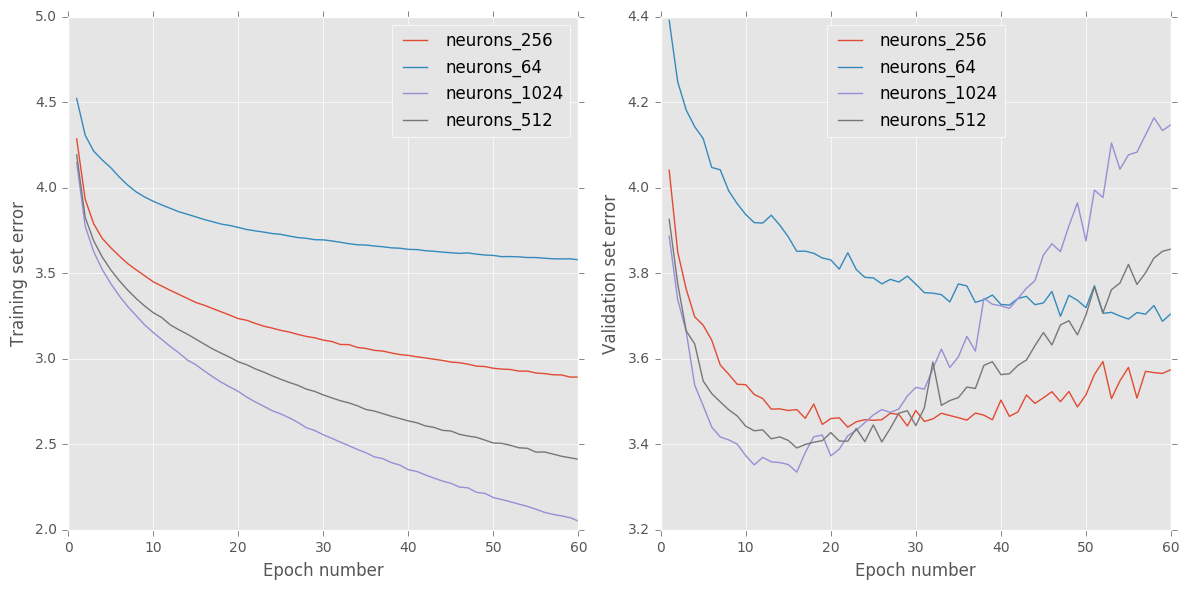

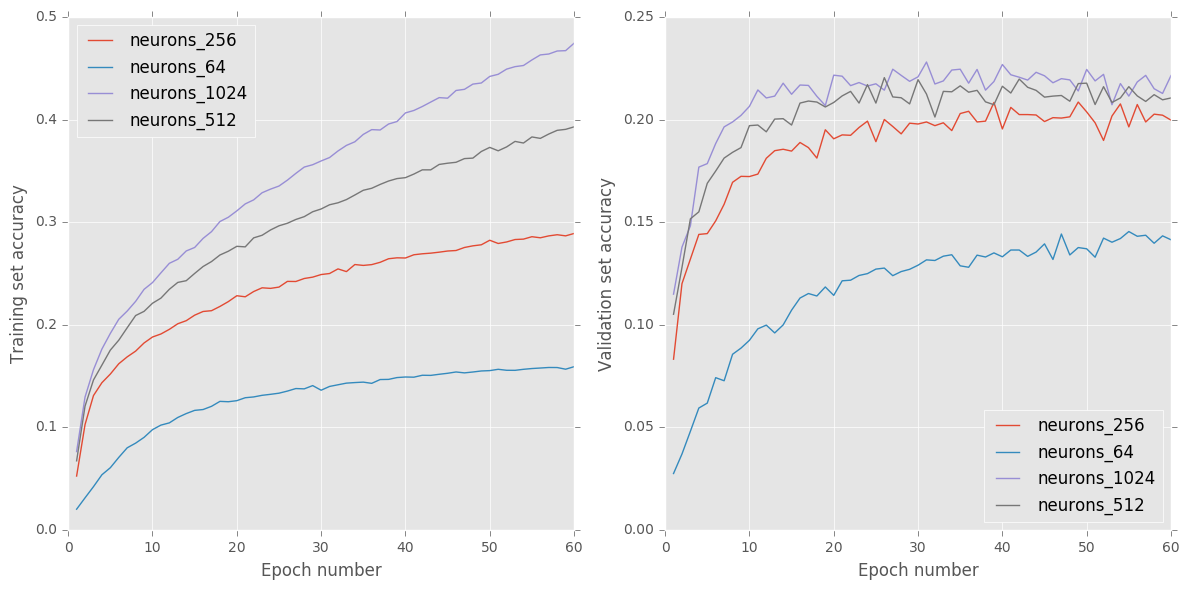

In [8]:
plot_error_and_accuracy(run_info,'CIFAR100_Layer_width')

### Experiment 2: Training with different number of Layers 

In [5]:
    run_info = {}
    num_hidden = 1024
    num_hidden_1 = int(num_hidden * 0.5)
    num_hidden_2 = int(num_hidden_1 * 0.5)
    num_hidden_3 = int(num_hidden_2 * 0.5)
    num_hidden_4 = int(num_hidden_3 * 0.5)
    labels = ['1_hidden_layer','2_hidden_layer','3_hidden_layer','4_hidden_layer','5_hidden_layer']



    tf.reset_default_graph()

    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    
    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                    stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, train_data.num_classes], 
                                                    stddev=2. / (num_hidden + train_data.num_classes)**0.5))
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([train_data.num_classes]))
    
        
    hidden_1 = tf.nn.relu(tf.matmul(inputs, weights_1) + biases_1)
    outputs = tf.matmul(hidden_1, weights_2) + biases_2


    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))

    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[0]))
        for e in range(60):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[0]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: 1_hidden_layer
End of epoch 05: err(train)=3.4485 acc(train)=0.1886
                 err(valid)=3.5161 acc(valid)=0.1763
End of epoch 10: err(train)=3.1739 acc(train)=0.2387
                 err(valid)=3.3672 acc(valid)=0.2089
End of epoch 15: err(train)=2.9706 acc(train)=0.2781
                 err(valid)=3.3552 acc(valid)=0.2153
End of epoch 20: err(train)=2.8128 acc(train)=0.3091
                 err(valid)=3.3965 acc(valid)=0.2178
End of epoch 25: err(train)=2.6771 acc(train)=0.3364
                 err(valid)=3.4461 acc(valid)=0.2217
End of epoch 30: err(train)=2.5549 acc(train)=0.3637
                 err(valid)=3.4941 acc(valid)=0.2281
End of epoch 35: err(train)=2.4491 acc(train)=0.3841
                 err(valid)=3.6584 acc(valid)=0.2210
End of epoch 40: err(train)=2.3463 acc(train)=0.4064
                 err(valid)=3.6925 acc(valid)=0.2175
End of epoch 45: err(train)=2.2667 acc(train)=0.4253
                 err(valid)=3.9122 acc(valid)=0.2112
End of epoch 50: err(tra

In [6]:
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
   

    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_1 + train_data.num_classes)**0.5))  
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
    biases_3 = tf.Variable(tf.zeros([train_data.num_classes]))
        

    hidden_1 = tf.nn.relu(tf.matmul(inputs, weights_1) + biases_1)
    hidden_2= tf.nn.relu(tf.matmul(hidden_1, weights_2) + biases_2)
    outputs = tf.matmul(hidden_2, weights_3) + biases_3

    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))

    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))

    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[1]))
        for e in range(60):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[1]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: 2_hidden_layer
End of epoch 05: err(train)=3.3071 acc(train)=0.2079
                 err(valid)=3.3859 acc(valid)=0.1965
End of epoch 10: err(train)=2.9057 acc(train)=0.2791
                 err(valid)=3.2884 acc(valid)=0.2193
End of epoch 15: err(train)=2.5647 acc(train)=0.3502
                 err(valid)=3.3540 acc(valid)=0.2269
End of epoch 20: err(train)=2.2519 acc(train)=0.4135
                 err(valid)=3.4826 acc(valid)=0.2399
End of epoch 25: err(train)=1.9661 acc(train)=0.4791
                 err(valid)=3.7562 acc(valid)=0.2296
End of epoch 30: err(train)=1.7231 acc(train)=0.5373
                 err(valid)=4.0971 acc(valid)=0.2288
End of epoch 35: err(train)=1.5132 acc(train)=0.5878
                 err(valid)=4.4081 acc(valid)=0.2222
End of epoch 40: err(train)=1.3269 acc(train)=0.6340
                 err(valid)=4.8758 acc(valid)=0.2218
End of epoch 45: err(train)=1.1625 acc(train)=0.6756
                 err(valid)=5.3803 acc(valid)=0.2111
End of epoch 50: err(tra

In [7]:
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    

    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                        stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
    weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_2 + train_data.num_classes)**0.5))
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
    biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
    biases_4 = tf.Variable(tf.zeros([train_data.num_classes]))
            
    hidden_1 = tf.nn.relu(tf.matmul(inputs, weights_1) + biases_1)
    hidden_2= tf.nn.relu(tf.matmul(hidden_1, weights_2) + biases_2)
    hidden_3 = tf.nn.relu(tf.matmul(hidden_2, weights_3) + biases_3)  

    outputs = tf.matmul(hidden_3, weights_4) + biases_4

    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))

    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()
    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[2]))
        for e in range(60):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[2]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: 3_hidden_layer
End of epoch 05: err(train)=3.3646 acc(train)=0.1915
                 err(valid)=3.4438 acc(valid)=0.1840
End of epoch 10: err(train)=2.9377 acc(train)=0.2680
                 err(valid)=3.3245 acc(valid)=0.2144
End of epoch 15: err(train)=2.5505 acc(train)=0.3475
                 err(valid)=3.4018 acc(valid)=0.2181
End of epoch 20: err(train)=2.1611 acc(train)=0.4339
                 err(valid)=3.6304 acc(valid)=0.2243
End of epoch 25: err(train)=1.8009 acc(train)=0.5184
                 err(valid)=4.0342 acc(valid)=0.2249
End of epoch 30: err(train)=1.4815 acc(train)=0.5976
                 err(valid)=4.5019 acc(valid)=0.2180
End of epoch 35: err(train)=1.2147 acc(train)=0.6638
                 err(valid)=5.1056 acc(valid)=0.2184
End of epoch 40: err(train)=0.9979 acc(train)=0.7199
                 err(valid)=5.7777 acc(valid)=0.2206
End of epoch 45: err(train)=0.8235 acc(train)=0.7619
                 err(valid)=6.5267 acc(valid)=0.2073
End of epoch 50: err(tra

In [9]:
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')

    
    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                        stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
    weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, num_hidden_3], 
                                                      stddev=2. / (num_hidden_2 + num_hidden_3)**0.5))
    weights_5 = tf.Variable(tf.truncated_normal([num_hidden_3, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_3 + train_data.num_classes)**0.5))
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
    biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
    biases_4 = tf.Variable(tf.zeros([num_hidden_3]))
    biases_5 = tf.Variable(tf.zeros([train_data.num_classes]))
            
    hidden_1 = tf.nn.relu(tf.matmul(inputs, weights_1) + biases_1)
    hidden_2= tf.nn.relu(tf.matmul(hidden_1, weights_2) + biases_2)
    hidden_3 = tf.nn.relu(tf.matmul(hidden_2, weights_3) + biases_3)
    hidden_4 = tf.nn.relu(tf.matmul(hidden_3, weights_4) + biases_4)  
    outputs = tf.matmul(hidden_4, weights_5) + biases_5

    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))

    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[3]))
        for e in range(60):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[3]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: 4_hidden_layer
End of epoch 05: err(train)=3.4746 acc(train)=0.1719
                 err(valid)=3.5824 acc(valid)=0.1540
End of epoch 10: err(train)=3.0921 acc(train)=0.2380
                 err(valid)=3.3542 acc(valid)=0.2067
End of epoch 15: err(train)=2.7653 acc(train)=0.3035
                 err(valid)=3.3469 acc(valid)=0.2189
End of epoch 20: err(train)=2.4214 acc(train)=0.3760
                 err(valid)=3.5173 acc(valid)=0.2187
End of epoch 25: err(train)=2.0884 acc(train)=0.4516
                 err(valid)=3.7994 acc(valid)=0.2184
End of epoch 30: err(train)=1.7542 acc(train)=0.5306
                 err(valid)=4.2224 acc(valid)=0.2124
End of epoch 35: err(train)=1.4795 acc(train)=0.5946
                 err(valid)=4.7660 acc(valid)=0.2106
End of epoch 40: err(train)=1.2504 acc(train)=0.6520
                 err(valid)=5.2803 acc(valid)=0.2057
End of epoch 45: err(train)=1.0493 acc(train)=0.7001
                 err(valid)=5.8723 acc(valid)=0.2046
End of epoch 50: err(tra

In [10]:
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')

    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                        stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
    weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, num_hidden_3], 
                                                      stddev=2. / (num_hidden_2 + num_hidden_3)**0.5))
    weights_5 = tf.Variable(tf.truncated_normal([num_hidden_3, num_hidden_4], 
                                                      stddev=2. / (num_hidden_3 + num_hidden_4)**0.5))
    weights_6 = tf.Variable(tf.truncated_normal([num_hidden_4, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_4 + train_data.num_classes)**0.5))
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
    biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
    biases_4 = tf.Variable(tf.zeros([num_hidden_3]))
    biases_5 = tf.Variable(tf.zeros([num_hidden_4]))
    biases_6 = tf.Variable(tf.zeros([train_data.num_classes]))
            
    hidden_1 = tf.nn.relu(tf.matmul(inputs, weights_1) + biases_1)
    hidden_2= tf.nn.relu(tf.matmul(hidden_1, weights_2) + biases_2)
    hidden_3 = tf.nn.relu(tf.matmul(hidden_2, weights_3) + biases_3)
    hidden_4 = tf.nn.relu(tf.matmul(hidden_3, weights_4) + biases_4)
    hidden_5 = tf.nn.relu(tf.matmul(hidden_4, weights_5) + biases_5)  
    outputs = tf.matmul(hidden_5, weights_6) + biases_6

    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))
    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[4]))
        for e in range(60):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[4]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))
    

Model: 5_hidden_layer
End of epoch 05: err(train)=3.5843 acc(train)=0.1525
                 err(valid)=3.5865 acc(valid)=0.1504
End of epoch 10: err(train)=3.2248 acc(train)=0.2151
                 err(valid)=3.3986 acc(valid)=0.1891
End of epoch 15: err(train)=2.9259 acc(train)=0.2712
                 err(valid)=3.3194 acc(valid)=0.2109
End of epoch 20: err(train)=2.6397 acc(train)=0.3284
                 err(valid)=3.3959 acc(valid)=0.2174
End of epoch 25: err(train)=2.3469 acc(train)=0.3906
                 err(valid)=3.5917 acc(valid)=0.2092
End of epoch 30: err(train)=2.0465 acc(train)=0.4591
                 err(valid)=3.9014 acc(valid)=0.2098
End of epoch 35: err(train)=1.7855 acc(train)=0.5218
                 err(valid)=4.3109 acc(valid)=0.2059
End of epoch 40: err(train)=1.5463 acc(train)=0.5792
                 err(valid)=4.7644 acc(valid)=0.2055
End of epoch 45: err(train)=1.3596 acc(train)=0.6244
                 err(valid)=5.3675 acc(valid)=0.1991
End of epoch 50: err(tra

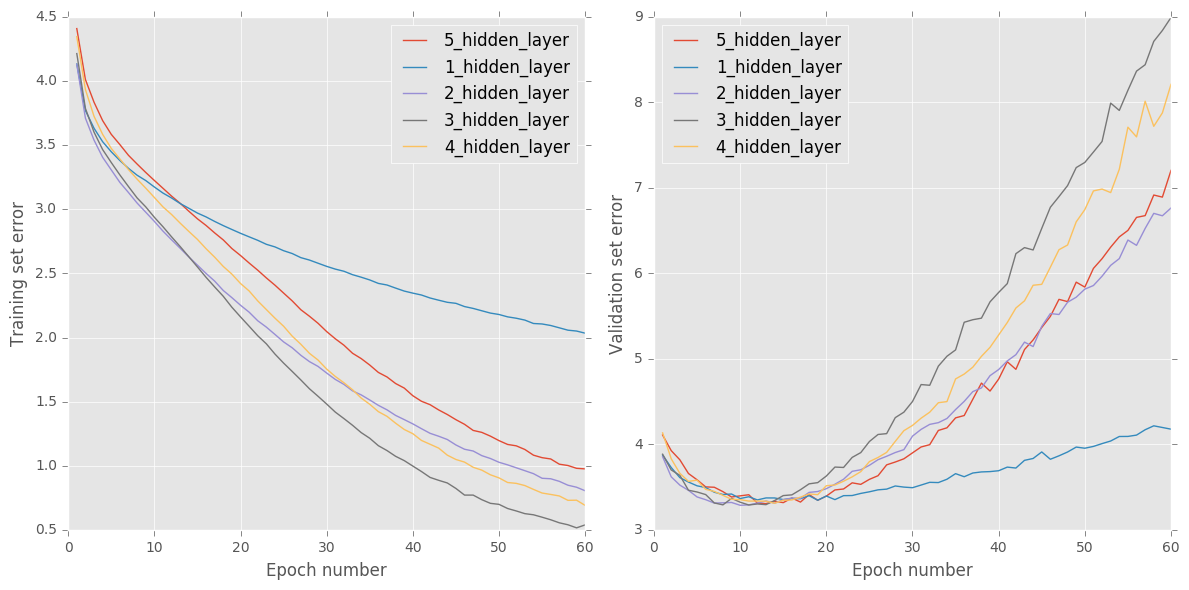

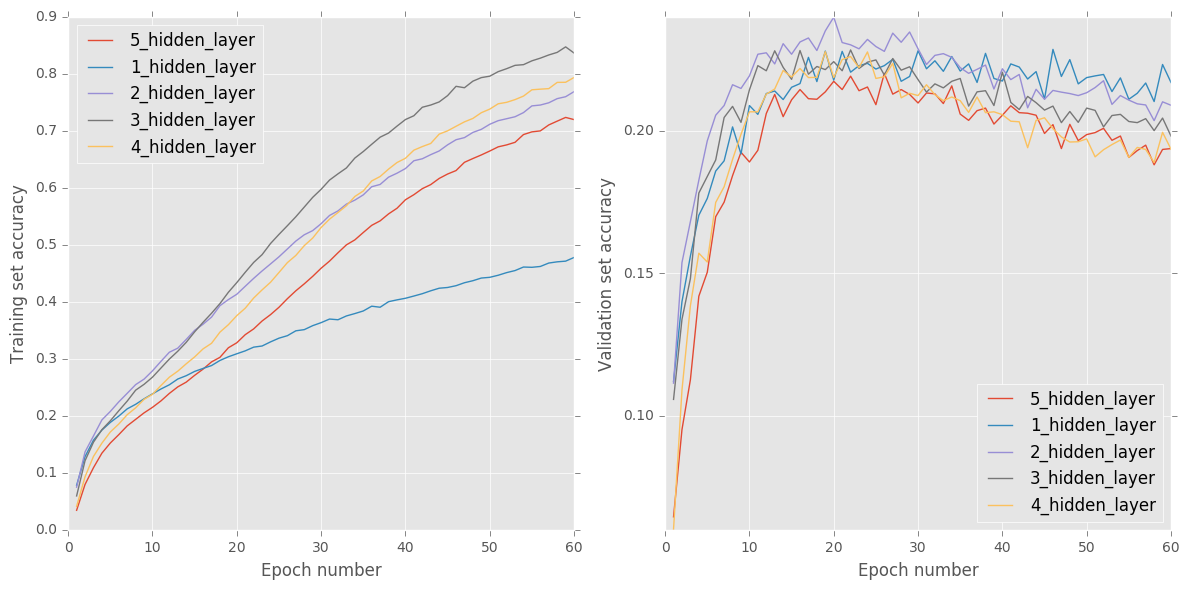

In [11]:
plot_error_and_accuracy(run_info,'CIFAR100_Number_of_layers')

### Training with different activation functions

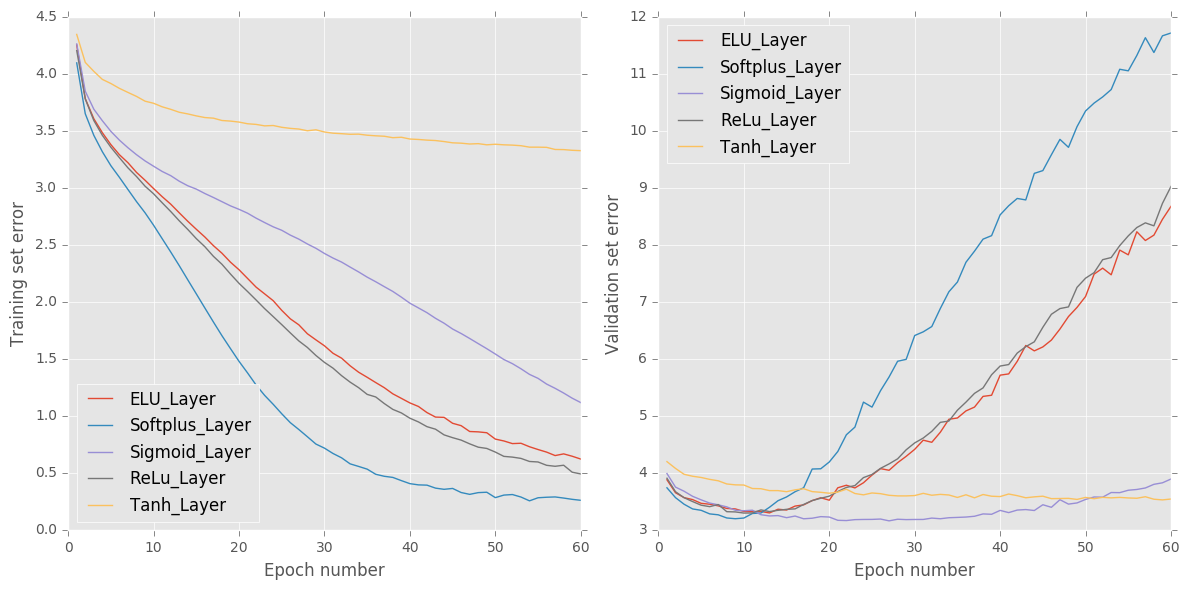

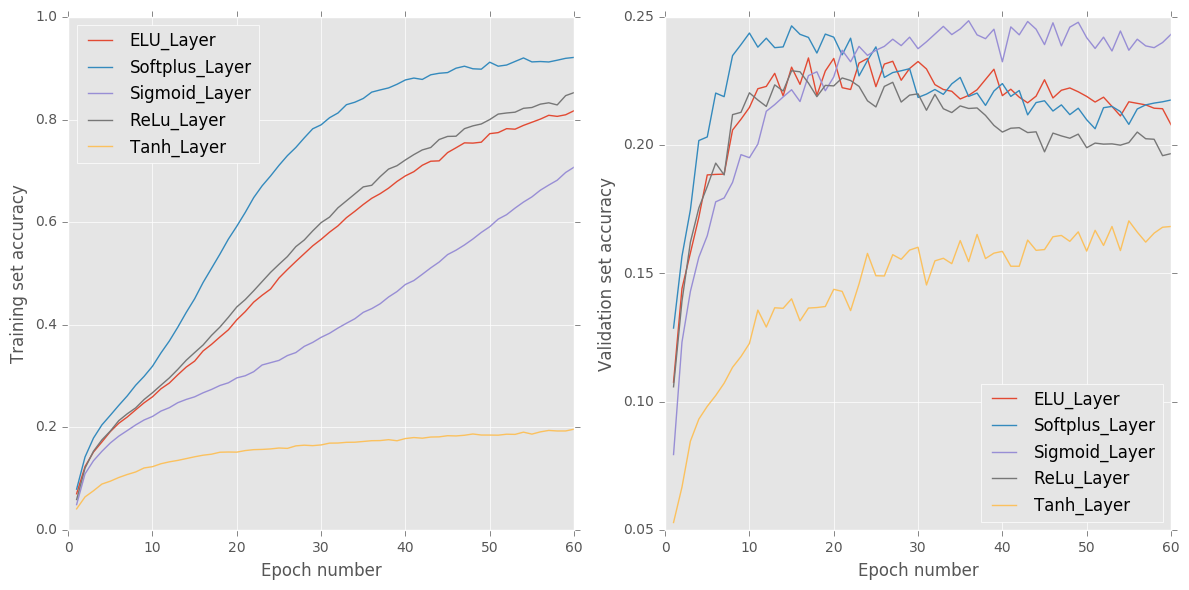

In [6]:
run = read_from_file('CIFAR100_Dropout_Activation_functions.txt')
plot_error_and_accuracy(run, 'CIFAR100_activation_functions')

### Experiment 3: Training with dropout

In [6]:
    run_info = {}
    num_hidden = 1024
    num_hidden_1 = int(num_hidden * 0.5)
    num_hidden_2 = int(num_hidden_1 * 0.5)
    num_hidden_3 = int(num_hidden_2 * 0.5)
    num_hidden_4 = int(num_hidden_3 * 0.5)
    labels = ['1_hidden_layer','2_hidden_layer','3_hidden_layer','4_hidden_layer','5_hidden_layer']

    tf.reset_default_graph()

    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    prob = tf.placeholder("float")
    
    
    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                    stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, train_data.num_classes], 
                                                    stddev=2. / (num_hidden + train_data.num_classes)**0.5))
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([train_data.num_classes]))
    
    #training
    hidden_1 = tf.nn.relu(tf.matmul(inputs, weights_1) + biases_1)
    hidden_1_dropout = tf.nn.dropout(hidden_1, prob)
  
    outputs = tf.matmul(hidden_1_dropout, weights_2) + biases_2

    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))    
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)),tf.float32))
        
    #Validation
    v_hidden_1 = tf.nn.relu(tf.matmul(inputs, weights_1) + biases_1)
    v_outputs = tf.matmul(v_hidden_1, weights_2) + biases_2
    
    v_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(v_outputs, targets))
    v_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(v_outputs, 1), tf.argmax(targets, 1)),tf.float32))

    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[0]))
        for e in range(60):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, prob: 0.9})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [v_error, v_accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[0]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: 1_hidden_layer
End of epoch 05: err(train)=3.5532 acc(train)=0.1675
                 err(valid)=3.5257 acc(valid)=0.1734
End of epoch 10: err(train)=3.3404 acc(train)=0.2070
                 err(valid)=3.4083 acc(valid)=0.2013
End of epoch 15: err(train)=3.1899 acc(train)=0.2313
                 err(valid)=3.3596 acc(valid)=0.2094
End of epoch 20: err(train)=3.0783 acc(train)=0.2542
                 err(valid)=3.3658 acc(valid)=0.2160
End of epoch 25: err(train)=2.9892 acc(train)=0.2726
                 err(valid)=3.3855 acc(valid)=0.2167
End of epoch 30: err(train)=2.8999 acc(train)=0.2872
                 err(valid)=3.4279 acc(valid)=0.2201
End of epoch 35: err(train)=2.8291 acc(train)=0.3014
                 err(valid)=3.5001 acc(valid)=0.2147
End of epoch 40: err(train)=2.7652 acc(train)=0.3123
                 err(valid)=3.5279 acc(valid)=0.2237
End of epoch 45: err(train)=2.7045 acc(train)=0.3276
                 err(valid)=3.5814 acc(valid)=0.2187
End of epoch 50: err(tra

In [7]:
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    prob = tf.placeholder("float")
   
 
    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_1 + train_data.num_classes)**0.5))  
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
    biases_3 = tf.Variable(tf.zeros([train_data.num_classes]))
        

    hidden_1 = tf.nn.relu(tf.matmul(inputs, weights_1) + biases_1)
    hidden_1_dropout = tf.nn.dropout(hidden_1, prob)
    hidden_2= tf.nn.relu(tf.matmul(hidden_1_dropout, weights_2) + biases_2)
    hidden_2_dropout = tf.nn.dropout(hidden_2, prob)

    outputs = tf.matmul(hidden_2_dropout, weights_3) + biases_3

    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))

    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))
    
    #Validation
    v_hidden_1 = tf.nn.relu(tf.matmul(inputs, weights_1) + biases_1)
    v_hidden_2= tf.nn.relu(tf.matmul(v_hidden_1, weights_2) + biases_2)
    
    v_outputs = tf.matmul(v_hidden_2, weights_3) + biases_3

    v_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(v_outputs, targets))
    
    v_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(v_outputs, 1), tf.argmax(targets, 1)), tf.float32))

    
    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[1]))
        for e in range(60):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, prob: 0.9})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [v_error, v_accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[1]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: 2_hidden_layer
End of epoch 05: err(train)=3.4713 acc(train)=0.1743
                 err(valid)=3.4268 acc(valid)=0.1895
End of epoch 10: err(train)=3.1711 acc(train)=0.2277
                 err(valid)=3.2843 acc(valid)=0.2146
End of epoch 15: err(train)=2.9474 acc(train)=0.2663
                 err(valid)=3.2443 acc(valid)=0.2272
End of epoch 20: err(train)=2.7699 acc(train)=0.2996
                 err(valid)=3.2356 acc(valid)=0.2377
End of epoch 25: err(train)=2.6245 acc(train)=0.3284
                 err(valid)=3.2738 acc(valid)=0.2358
End of epoch 30: err(train)=2.4876 acc(train)=0.3543
                 err(valid)=3.3501 acc(valid)=0.2357
End of epoch 35: err(train)=2.3822 acc(train)=0.3782
                 err(valid)=3.4227 acc(valid)=0.2333
End of epoch 40: err(train)=2.2794 acc(train)=0.4007
                 err(valid)=3.4465 acc(valid)=0.2396
End of epoch 45: err(train)=2.1984 acc(train)=0.4204
                 err(valid)=3.5485 acc(valid)=0.2307
End of epoch 50: err(tra

In [8]:
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    prob = tf.placeholder("float")
    
    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                        stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
    weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_2 + train_data.num_classes)**0.5))
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
    biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
    biases_4 = tf.Variable(tf.zeros([train_data.num_classes]))

    hidden_1 = tf.nn.relu(tf.matmul(inputs, weights_1) + biases_1)
    hidden_1_dropout = tf.nn.dropout(hidden_1, prob)
    hidden_2= tf.nn.relu(tf.matmul(hidden_1_dropout, weights_2) + biases_2)
    hidden_2_dropout = tf.nn.dropout(hidden_2, prob)

    hidden_3 = tf.nn.relu(tf.matmul(hidden_2_dropout, weights_3) + biases_3)
    hidden_3_dropout = tf.nn.dropout(hidden_3, prob)
    
    outputs = tf.matmul(hidden_3_dropout, weights_4) + biases_4

    
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))
        
    #Validation
    v_hidden_1 = tf.nn.relu(tf.matmul(inputs, weights_1) + biases_1)
    v_hidden_2= tf.nn.relu(tf.matmul(v_hidden_1, weights_2) + biases_2)
    v_hidden_3 = tf.nn.relu(tf.matmul(v_hidden_2, weights_3) + biases_3)  

    v_outputs = tf.matmul(v_hidden_3, weights_4) + biases_4

 
    v_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(v_outputs, targets))

    v_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(v_outputs, 1), tf.argmax(targets, 1)),tf.float32))

    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[2]))
        for e in range(60):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, prob: 0.9})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [v_error, v_accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[2]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: 3_hidden_layer
End of epoch 05: err(train)=3.5838 acc(train)=0.1510
                 err(valid)=3.4908 acc(valid)=0.1719
End of epoch 10: err(train)=3.2734 acc(train)=0.2055
                 err(valid)=3.3474 acc(valid)=0.1999
End of epoch 15: err(train)=3.0788 acc(train)=0.2397
                 err(valid)=3.2507 acc(valid)=0.2169
End of epoch 20: err(train)=2.9211 acc(train)=0.2665
                 err(valid)=3.2232 acc(valid)=0.2267
End of epoch 25: err(train)=2.7741 acc(train)=0.2937
                 err(valid)=3.2492 acc(valid)=0.2271
End of epoch 30: err(train)=2.6447 acc(train)=0.3186
                 err(valid)=3.2737 acc(valid)=0.2350
End of epoch 35: err(train)=2.5374 acc(train)=0.3420
                 err(valid)=3.3346 acc(valid)=0.2288
End of epoch 40: err(train)=2.4465 acc(train)=0.3590
                 err(valid)=3.3555 acc(valid)=0.2327
End of epoch 45: err(train)=2.3548 acc(train)=0.3780
                 err(valid)=3.3877 acc(valid)=0.2359
End of epoch 50: err(tra

In [9]:
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    prob = tf.placeholder("float")

    

    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                        stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
    weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, num_hidden_3], 
                                                      stddev=2. / (num_hidden_2 + num_hidden_3)**0.5))
    weights_5 = tf.Variable(tf.truncated_normal([num_hidden_3, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_3 + train_data.num_classes)**0.5))
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
    biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
    biases_4 = tf.Variable(tf.zeros([num_hidden_3]))
    biases_5 = tf.Variable(tf.zeros([train_data.num_classes]))
            

    hidden_1 = tf.nn.relu(tf.matmul(inputs, weights_1) + biases_1)
    hidden_1_dropout = tf.nn.dropout(hidden_1, prob)
    hidden_2= tf.nn.relu(tf.matmul(hidden_1_dropout, weights_2) + biases_2)
    hidden_2_dropout = tf.nn.dropout(hidden_2, prob)
    hidden_3 = tf.nn.relu(tf.matmul(hidden_2_dropout, weights_3) + biases_3)
    hidden_3_dropout = tf.nn.dropout(hidden_3, prob)
    hidden_4 = tf.nn.relu(tf.matmul(hidden_3_dropout, weights_4) + biases_4)
    hidden_4_dropout = tf.nn.dropout(hidden_4, prob)
    outputs = tf.matmul(hidden_4_dropout, weights_5) + biases_5

    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))
        
    v_hidden_1 = tf.nn.relu(tf.matmul(inputs, weights_1) + biases_1)
    v_hidden_2 = tf.nn.relu(tf.matmul(v_hidden_1, weights_2) + biases_2)
    v_hidden_3 = tf.nn.relu(tf.matmul(v_hidden_2, weights_3) + biases_3)
    v_hidden_4 = tf.nn.relu(tf.matmul(v_hidden_3, weights_4) + biases_4)  
    
    v_outputs = tf.matmul(v_hidden_4, weights_5) + biases_5


    v_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(v_outputs, targets))

    v_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(v_outputs, 1), tf.argmax(targets, 1)), tf.float32))

    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[3]))
        for e in range(60):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, prob: 0.9})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [v_error, v_accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[3]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: 4_hidden_layer
End of epoch 05: err(train)=3.7196 acc(train)=0.1260
                 err(valid)=3.6836 acc(valid)=0.1355
End of epoch 10: err(train)=3.4458 acc(train)=0.1750
                 err(valid)=3.4295 acc(valid)=0.1815
End of epoch 15: err(train)=3.2848 acc(train)=0.2026
                 err(valid)=3.3028 acc(valid)=0.2088
End of epoch 20: err(train)=3.1565 acc(train)=0.2257
                 err(valid)=3.3004 acc(valid)=0.2113
End of epoch 25: err(train)=3.0534 acc(train)=0.2437
                 err(valid)=3.2986 acc(valid)=0.2127
End of epoch 30: err(train)=2.9705 acc(train)=0.2573
                 err(valid)=3.2158 acc(valid)=0.2281
End of epoch 35: err(train)=2.8942 acc(train)=0.2717
                 err(valid)=3.2501 acc(valid)=0.2232
End of epoch 40: err(train)=2.8160 acc(train)=0.2870
                 err(valid)=3.2813 acc(valid)=0.2289
End of epoch 45: err(train)=2.7584 acc(train)=0.2984
                 err(valid)=3.3122 acc(valid)=0.2216
End of epoch 50: err(tra

In [10]:
    tf.reset_default_graph()
    train_data.reset()
    valid_data.reset()
    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    prob = tf.placeholder("float")

    weights_1 = tf.Variable(tf.truncated_normal([train_data.inputs.shape[1], num_hidden], 
                                                      stddev=2. / (train_data.inputs.shape[1] + num_hidden)**0.5))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden_1], 
                                                        stddev=2. / (num_hidden + num_hidden_1)**0.5))
    weights_3 = tf.Variable(tf.truncated_normal([num_hidden_1, num_hidden_2], 
                                                        stddev=2. / (num_hidden_1 + num_hidden_2)**0.5))
    weights_4 = tf.Variable(tf.truncated_normal([num_hidden_2, num_hidden_3], 
                                                      stddev=2. / (num_hidden_2 + num_hidden_3)**0.5))
    weights_5 = tf.Variable(tf.truncated_normal([num_hidden_3, num_hidden_4], 
                                                      stddev=2. / (num_hidden_3 + num_hidden_4)**0.5))
    weights_6 = tf.Variable(tf.truncated_normal([num_hidden_4, train_data.num_classes], 
                                                      stddev=2. / (num_hidden_4 + train_data.num_classes)**0.5))
    biases_1 = tf.Variable(tf.zeros([num_hidden]))
    biases_2 = tf.Variable(tf.zeros([num_hidden_1]))
    biases_3 = tf.Variable(tf.zeros([num_hidden_2]))
    biases_4 = tf.Variable(tf.zeros([num_hidden_3]))
    biases_5 = tf.Variable(tf.zeros([num_hidden_4]))
    biases_6 = tf.Variable(tf.zeros([train_data.num_classes]))
            
    hidden_1 = tf.nn.relu(tf.matmul(inputs, weights_1) + biases_1)
    hidden_1_dropout = tf.nn.dropout(hidden_1, prob)
    hidden_2 = tf.nn.relu(tf.matmul(hidden_1_dropout, weights_2) + biases_2)
    hidden_2_dropout = tf.nn.dropout(hidden_2, prob)
    hidden_3 = tf.nn.relu(tf.matmul(hidden_2_dropout, weights_3) + biases_3)
    hidden_3_dropout = tf.nn.dropout(hidden_3, prob)
    hidden_4 = tf.nn.relu(tf.matmul(hidden_3_dropout, weights_4) + biases_4)
    hidden_4_dropout = tf.nn.dropout(hidden_4, prob)
    hidden_5 = tf.nn.relu(tf.matmul(hidden_4_dropout, weights_5) + biases_5)
    hidden_5_dropout = tf.nn.dropout(hidden_5, prob)
    outputs = tf.matmul(hidden_5_dropout, weights_6) + biases_6
    
    error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), tf.float32))
    
    #Validation
    v_hidden_1 = tf.nn.relu(tf.matmul(inputs, weights_1) + biases_1)
    v_hidden_2 = tf.nn.relu(tf.matmul(v_hidden_1, weights_2) + biases_2)
    v_hidden_3 = tf.nn.relu(tf.matmul(v_hidden_2, weights_3) + biases_3)
    v_hidden_4 = tf.nn.relu(tf.matmul(v_hidden_3, weights_4) + biases_4)
    v_hidden_5 = tf.nn.relu(tf.matmul(v_hidden_4, weights_5) + biases_5)  
    v_outputs = tf.matmul(v_hidden_5, weights_6) + biases_6

    v_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(v_outputs, targets))
    v_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(v_outputs, 1), tf.argmax(targets, 1)),tf.float32))
    
    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)

    init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session() as sess:
        sess.run(init)
        print('Model: {}'.format(labels[4]))
        for e in range(60):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, prob: 0.9})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [v_error, v_accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        run_info[labels[4]] = (error_all,acc_all,error_valid_all, acc_valid_all)
        print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))

Model: 5_hidden_layer
End of epoch 05: err(train)=3.8934 acc(train)=0.0987
                 err(valid)=3.7410 acc(valid)=0.1249
End of epoch 10: err(train)=3.6428 acc(train)=0.1391
                 err(valid)=3.5851 acc(valid)=0.1577
End of epoch 15: err(train)=3.4932 acc(train)=0.1636
                 err(valid)=3.4450 acc(valid)=0.1854
End of epoch 20: err(train)=3.3735 acc(train)=0.1863
                 err(valid)=3.3720 acc(valid)=0.1975
End of epoch 25: err(train)=3.2965 acc(train)=0.2009
                 err(valid)=3.3416 acc(valid)=0.2020
End of epoch 30: err(train)=3.2159 acc(train)=0.2167
                 err(valid)=3.3500 acc(valid)=0.2076
End of epoch 35: err(train)=3.1527 acc(train)=0.2266
                 err(valid)=3.2948 acc(valid)=0.2124
End of epoch 40: err(train)=3.0865 acc(train)=0.2382
                 err(valid)=3.2970 acc(valid)=0.2148
End of epoch 45: err(train)=3.0273 acc(train)=0.2486
                 err(valid)=3.2942 acc(valid)=0.2177
End of epoch 50: err(tra

In [11]:
write_to_file('CIAFR100_dropout_layers', run_info)

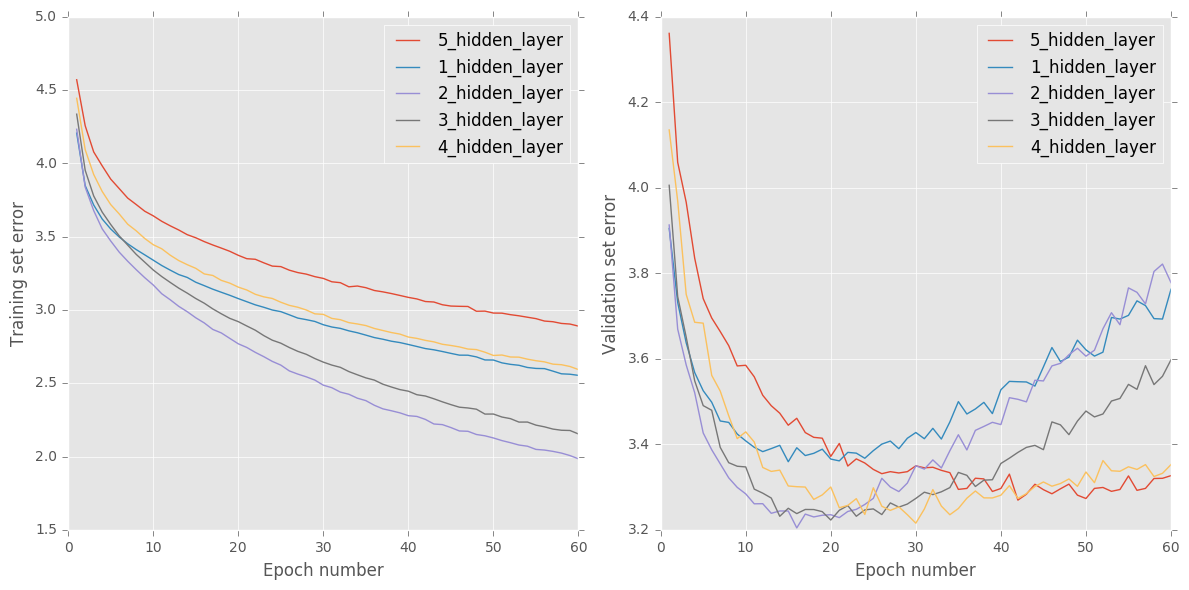

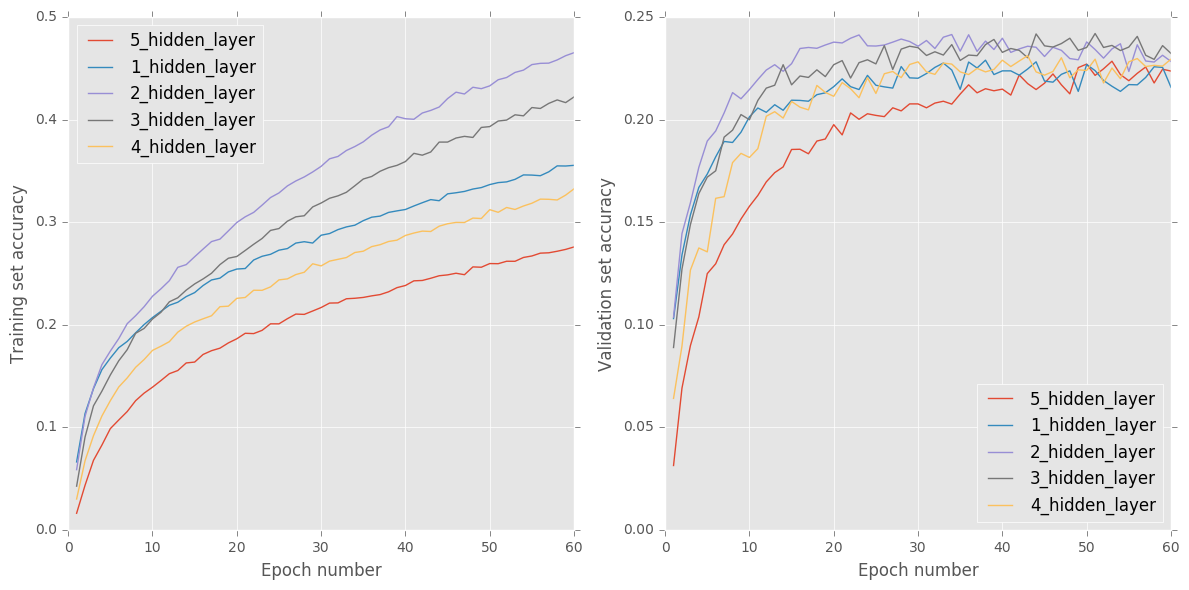

In [12]:
plot_error_and_accuracy(run_info, 'CIFAR100_layers_wDropout')

### Training with regularization

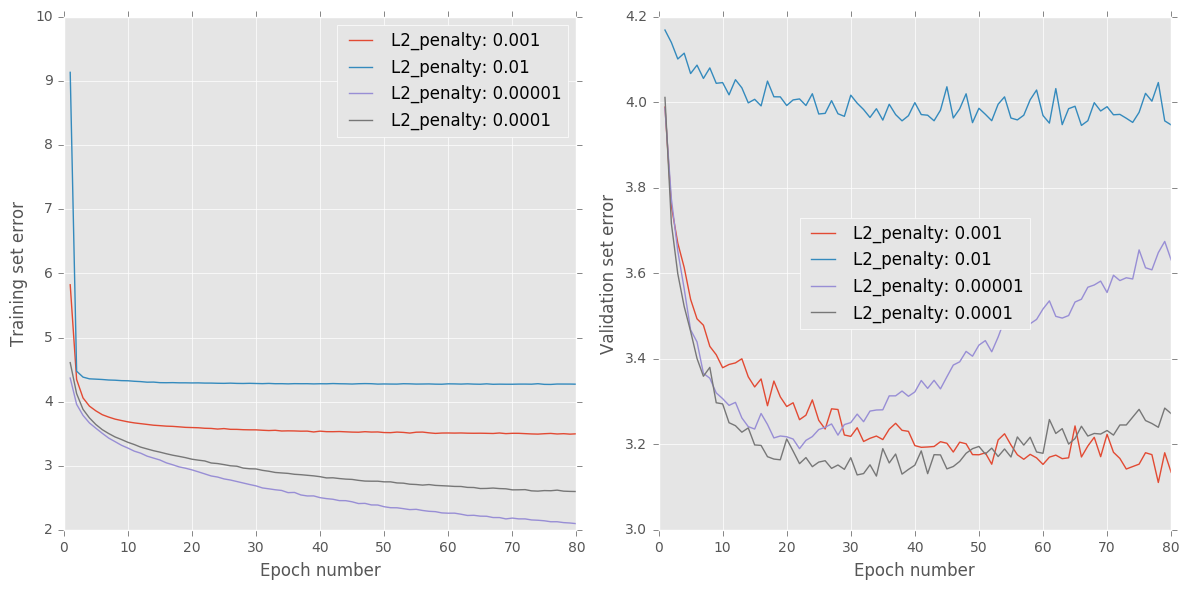

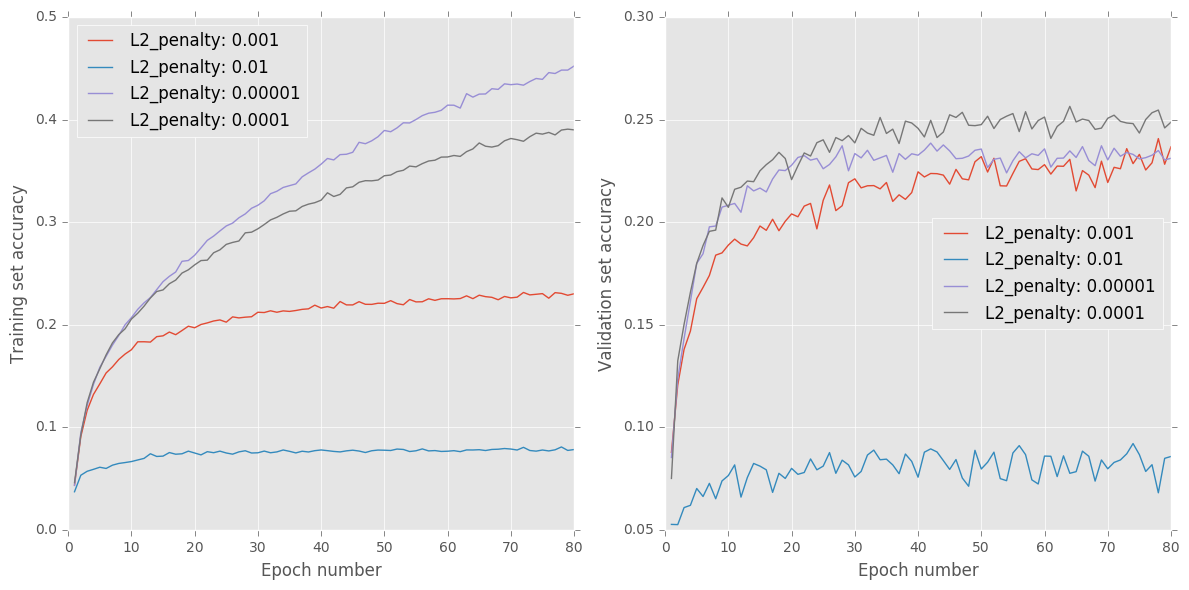

In [16]:
run = read_from_file('CIFAR100_Dropout_regularizers.txt')
plot_error_and_accuracy(run, 'CIFAR100_layers_wReg')


In [ ]:
#tf.reset_default_graph()
graph = tf.Graph() #create new graph

with graph.as_default():
    x = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    y_ = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    keep_prob = tf.placeholder(tf.float32)
    #flag = tf.placeholder(tf.bool)
    
    x_image = tf.reshape(x, [-1,32,32,3]) #batch_size, IMAGE_SIZE, IMAGE_SIZE, 3

    W_conv1 = weight_variable([2, 2, 3, 120]) #
    b_conv1 = bias_variable([120])
    h_conv1 = tf.nn.elu(conv2d(x_image, W_conv1) + b_conv1)
    
    
    W_conv12 = weight_variable([2, 2, 120, 120]) #
    b_conv12 = bias_variable([120])
    h_conv12 = tf.nn.elu(conv2d(h_conv1, W_conv12) + b_conv12)

    h_pool1 = max_pool_2x2(h_conv12)
    
    W_conv2 = weight_variable([2, 2, 120, 240])
    b_conv2 = bias_variable([240])
    h_conv2 = tf.nn.elu(conv2d(h_pool1, W_conv2) + b_conv2)
    drop_2 = tf.nn.dropout(h_conv2, keep_prob)
    
    W_conv22 = weight_variable([2, 2, 240, 240])
    b_conv22 = bias_variable([240])
    h_conv22 = tf.nn.elu(conv2d(drop_2, W_conv22) + b_conv22)
    drop_2 = tf.nn.dropout(h_conv22, keep_prob)
    
    h_pool2 = max_pool_2x2(drop_2)
    
    #h_pool2_flat = tf.reshape(h_pool2, [x.batch_size,-1])
    #dim = h_pool2_flat.get_shape()[1].value
    W_fc1 = weight_variable([15360, 1024])
    b_fc1 = bias_variable([1024])
    
    h_pool2_flat = tf.reshape(h_pool2, [-1, 15360])
    h_fc1 = tf.nn.elu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    W_fc2 = weight_variable([1024, 100])
    b_fc2 = bias_variable([100])

    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    with tf.name_scope('error'):
        #regularizers = tf.reduce_sum(tf.square(W_conv1)) + tf.reduce_sum(tf.square(W_conv2)) +\
         #               tf.reduce_sum(tf.square(W_fc1)) + tf.reduce_sum(tf.square(W_fc2))
        per_datapoint_errors = tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=y_conv)
        error = tf.reduce_mean(per_datapoint_errors)

    with tf.name_scope('accuracy'):
        per_datapoint_pred_is_correct = tf.equal(tf.argmax(y_conv, axis=1), tf.argmax(y_, axis=1))
        accuracy = tf.reduce_mean(tf.cast(per_datapoint_pred_is_correct, tf.float32))

    with tf.name_scope('training'):
        train_step = tf.train.AdamOptimizer(0.0005).minimize(error)
    init = tf.global_variables_initializer()

    
acc_all=[]
error_all=[]
acc_valid_all=[]
error_valid_all=[]
with tf.Session(graph=graph,config=config) as sess:
        sess.run(init)
        for e in range(30):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={x: input_batch, y_: target_batch, keep_prob: 0.9})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches
            error_all.append(running_error)
            acc_all.append(running_accuracy)
            if (e + 1) % 5 == 0:
                print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                          .format(e + 1, running_error, running_accuracy))
        
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={x: input_batch, y_: target_batch, keep_prob: 1})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            error_valid_all.append(valid_error)
            acc_valid_all.append(valid_accuracy)
            if (e + 1) % 5 == 0:
                print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                        .format(valid_error, valid_accuracy))
        test_inputs = np.load(os.path.join(os.environ['MLP_DATA_DIR'], 'cifar-100-test-inputs.npz'))['inputs']
        test_predictions = sess.run(tf.nn.softmax(y_conv), feed_dict={x: test_inputs, keep_prob:1})
        print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
        print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))